# Comparison of random forest, logistic regression and xgboost model

In [1]:
import numpy as np
from numpy import sort
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

import sklearn.metrics as metrics
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

import warnings

### Random seed to ensure reproductible runs

In [2]:
RSEED = 50

### Set up colorbar

In [3]:
cmap = mpl.cm.get_cmap('BrBG')

In [4]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced_clean/df_modelling.csv', index_col='rgiid')
df_main.columns

/home/colili/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['x', 'y', 'Surge', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'Area',
       'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax', 'Status', 'Connect',
       'Form', 'TermType', 'Linkages', 'Name', 'check_geom', 'geometry', 'bed',
       'thickness', 'surface_elevation', 'width_centerline', 'Runoff', 'ELA',
       'beta', 'cmb', 'Bed_slope', 'Surface_slope', 'WHsin', 'WH', 'dummy',
       'SMB_calc'],
      dtype='object')

In [5]:
df_main

,x,y,Surge,BgnDate,EndDate,CenLon,CenLat,Area,Zmin,Zmax,...,Runoff,ELA,beta,cmb,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00004,524634.335707,8.539882e+06,0,20080901,-9999999,15.9932,76.9423,1.044,665,933,...,1.110227,431.471268,0.005068,1.388794,NaN,NaN,NaN,NaN,0.726012,NaN
RGI60-07.00004,524633.930457,8.539906e+06,0,20080901,-9999999,15.9932,76.9423,1.044,665,933,...,1.105706,431.784498,0.005069,1.394411,NaN,NaN,NaN,NaN,0.970469,NaN
RGI60-07.00004,524657.521964,8.539931e+06,0,20080901,-9999999,15.9932,76.9423,1.044,665,933,...,1.100061,432.103017,0.005069,1.392706,NaN,NaN,NaN,0.090480,0.945853,2.447634
RGI60-07.00004,524681.113471,8.539955e+06,0,20080901,-9999999,15.9932,76.9423,1.044,665,933,...,1.094416,432.421537,0.005068,1.391001,12.654898,3.372262,809.523242,0.104519,0.807044,2.435692
RGI60-07.00004,524704.704977,8.539980e+06,0,20080901,-9999999,15.9932,76.9423,1.044,665,933,...,1.088771,432.740057,0.005068,1.389296,12.654898,3.372262,904.899185,0.093502,0.309744,2.433887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,534310.362510,8.675249e+06,3,20040713,-9999999,16.5502,78.1217,5.350,304,970,...,2.127417,627.625366,0.004614,-1.423469,4.401905,7.893963,-11421.363223,0.181951,0.236503,-1.604864
RGI60-07.01567,534309.250485,8.675291e+06,3,20040713,-9999999,16.5502,78.1217,5.350,304,970,...,2.076787,627.625366,0.004618,-1.395654,4.401905,7.893963,-10608.299012,0.195897,0.093612,-1.606379
RGI60-07.01567,534308.138459,8.675333e+06,3,20040713,-9999999,16.5502,78.1217,5.350,304,970,...,2.005969,627.625366,0.004620,-1.382369,-0.158243,-0.761801,-1682.075458,0.208355,0.176144,-1.604294


In [6]:
df_main.drop(df_main[df_main['Surge']==9].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==1].index, inplace = True)
# df_main.drop(df_main[df_main['Surge']==2].index, inplace = True)
# df = df_main.drop(columns = ['Unnamed: 0','x', 'y', 'ELA', 'beta', 'Name', 'Area'])
df = df_main.drop(columns = ['x', 'y', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'Area',
       'Zmin', 'Zmax', 'Zmed', 'Aspect', 'Lmax', 'Status', 'Connect',
       'Form', 'Linkages', 'Name', 'check_geom', 'geometry', 'ELA', 'beta',
        'Slope', 'TermType', 'cmb'])
df.dropna(how='any', inplace=True)
df

,Surge,bed,thickness,surface_elevation,width_centerline,Runoff,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc
rgiid,,,,,,,,,,,,
RGI60-07.00004,0,882.06460,30.935455,913.00000,295.980219,1.094416,12.654898,3.372262,809.523242,0.104519,0.807044,2.435692
RGI60-07.00004,0,882.06460,30.935455,913.00000,330.851846,1.088771,12.654898,3.372262,904.899185,0.093502,0.309744,2.433887
RGI60-07.00004,0,882.06460,30.935455,913.00000,342.886985,1.083127,12.654898,3.372262,937.815996,0.090221,0.810271,2.432082
RGI60-07.00004,0,881.31860,34.681380,916.00000,336.403639,1.077530,1.259105,-5.051115,11104.786522,0.103095,0.264539,2.445479
RGI60-07.00004,0,874.88640,35.113590,910.00000,330.094736,1.081518,15.003054,14.036142,7510.436075,0.106374,0.822424,2.414392
...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,3,237.64468,50.380424,288.02512,278.553621,2.123592,-13.251281,-10.615210,-8877.735508,0.180864,0.732077,-1.566323
RGI60-07.01567,3,233.07228,46.717087,279.78937,256.755923,2.127417,4.401905,7.893963,-11421.363223,0.181951,0.236503,-1.604864
RGI60-07.01567,3,233.07228,46.717087,279.78937,238.477978,2.076787,4.401905,7.893963,-10608.299012,0.195897,0.093612,-1.606379


In [7]:
df.groupby('Surge').count()

,bed,thickness,surface_elevation,width_centerline,Runoff,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc
Surge,,,,,,,,,,,
0,66693,66693,66693,66693,66693,66693,66693,66693,66693,66693,66693
2,4195,4195,4195,4195,4195,4195,4195,4195,4195,4195,4195
3,10742,10742,10742,10742,10742,10742,10742,10742,10742,10742,10742


In [8]:
df['Surge'] = df['Surge'].replace({2: 1, 3: 1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    66693
1    14937
Name: label, dtype: int64

## Undersampling of the minority class

In [9]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [10]:
df_downsampled.columns

Index(['label', 'bed', 'thickness', 'surface_elevation', 'width_centerline',
       'Runoff', 'Bed_slope', 'Surface_slope', 'WHsin', 'WH', 'dummy',
       'SMB_calc'],
      dtype='object')

# Split in test/train

In [11]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

## Evaluation of the decision tree function

In [12]:
def evaluate_model(predictions, probs, train_predictions, train_probs, color):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    
    plt.figure(figsize = (8, 8))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')
    plt.plot(model_fpr, model_tpr, color, label = 'model')
    plt.text(s = 'AUC = ' + str(round(roc_auc_score(train_labels, train_probs),2))
    , x=0.6, y=0.0, fontsize=15
)
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

## Confusion matrix function

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    cbar = plt.colorbar(aspect=4)
    plt.clim(0,100)
    cbar.set_label('Fraction (%)')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
#                  color="black" if cm[i, j] > thresh else "white")
                 color="black")

        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Gradient boosted

In [14]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [15]:
trainprob = train.copy()
trainprob['y'] = train_labels

trainprob.corr()

,bed,thickness,surface_elevation,width_centerline,Runoff,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,y
bed,1.000000,-0.428884,0.916175,-0.218851,-0.637997,0.401180,0.421920,-0.038511,-0.120824,0.002222,0.739830,-0.293569
thickness,-0.428884,1.000000,-0.030887,0.460814,0.010814,-0.410258,-0.481567,0.129253,0.148493,0.001806,0.040862,0.338883
surface_elevation,0.916175,-0.030887,1.000000,-0.037707,-0.701115,0.261874,0.253186,0.014733,-0.067807,0.003259,0.836714,-0.174473
width_centerline,-0.218851,0.460814,-0.037707,1.000000,-0.094565,-0.218507,-0.248442,0.235728,-0.213099,0.008692,0.115580,0.217909
Runoff,-0.637997,0.010814,-0.701115,-0.094565,1.000000,-0.174025,-0.191188,-0.045225,0.029589,0.003930,-0.717924,0.222589
Bed_slope,0.401180,-0.410258,0.261874,-0.218507,-0.174025,1.000000,0.899259,-0.023209,-0.070167,-0.000669,0.192047,-0.278739
Surface_slope,0.421920,-0.481567,0.253186,-0.248442,-0.191188,0.899259,1.000000,-0.035272,-0.080161,0.002707,0.177837,-0.334438
WHsin,-0.038511,0.129253,0.014733,0.235728,-0.045225,-0.023209,-0.035272,1.000000,-0.031711,0.013761,0.034661,0.035848
WH,-0.120824,0.148493,-0.067807,-0.213099,0.029589,-0.070167,-0.080161,-0.031711,1.000000,0.004390,-0.105476,-0.035135
dummy,0.002222,0.001806,0.003259,0.008692,0.003930,-0.000669,0.002707,0.013761,0.004390,1.000000,-0.003114,0.004182


In [16]:
params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.5}

xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

[16:16:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [17]:
predictions_xgboost = xgb.predict(dmatrix_test)

In [18]:
pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced_clean/ROC_curve/df_eval_xgboost.csv')

Text(0.6, 0.0, 'AUC = 0.8')

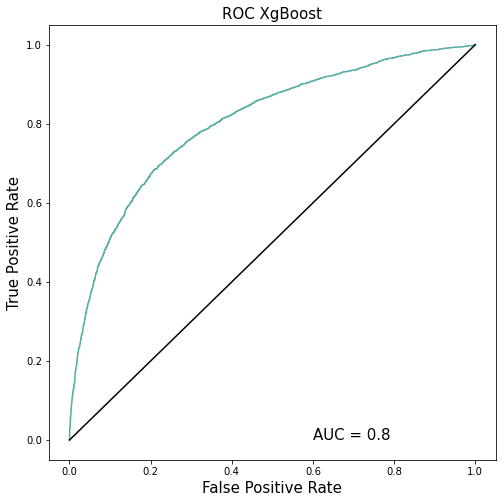

In [19]:
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(fpr, tpr, color=cmap(0.75))
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

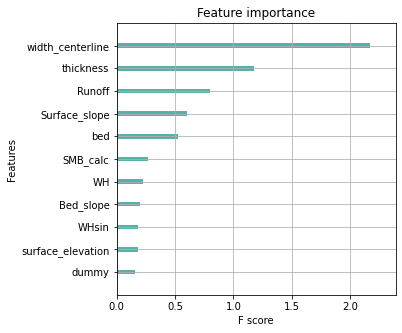

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, importance_type = 'gain', show_values=False, ax=ax, color=cmap(0.75))
plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/feature_xgboost_gain.pdf', bbox_inches='tight')

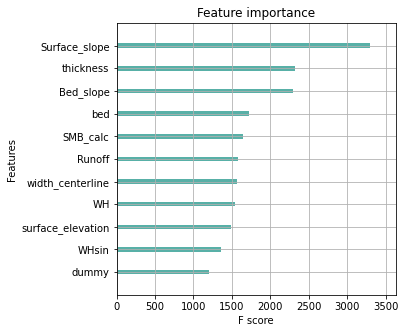

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, importance_type = 'weight', show_values=False, ax=ax, color=cmap(0.75))
plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/feature_xgboost_weight.pdf', bbox_inches='tight')

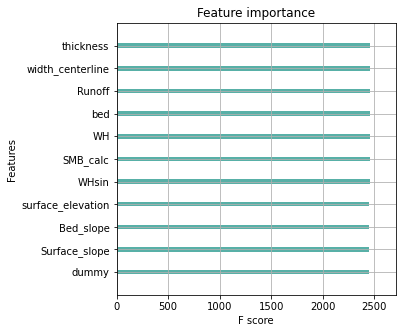

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, importance_type = 'cover', show_values=False, ax=ax, color=cmap(0.75))
plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/feature_xgboost_cover.pdf', bbox_inches='tight')

<ipython-input-51-5869d6dc2918>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0.5, 1, 1.5, 2], fontsize=15)
<ipython-input-51-5869d6dc2918>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([0, 1000, 2000, 3000], fontsize=15)


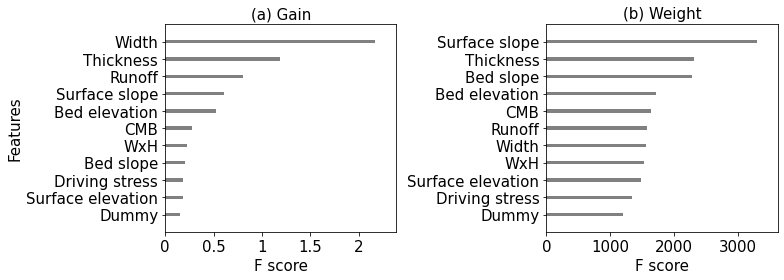

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
xgboost.plot_importance(xgb, importance_type = 'gain', show_values=False, ax=ax1, color='grey', title='(a) Gain', grid=False)
xgboost.plot_importance(xgb, importance_type = 'weight', show_values=False, ax=ax2, color='grey', title='(b) Weight', grid=False, ylabel=None)
name_gain = ["Terminus type", "Width", "Thickness", "Runoff", "Slope", "Bed elevation", "CMB", "Surface elevation", "WxH", "Driving stress", "Dummy"]
name_weight = ['Slope', 'Thickness', 'Runoff', 'Dummy', 'Width', 'CMB', 'Bed elevation', 'WxH', 'Surface elevation', 'Driving stress', 'Terminus Type']
name_gain = ['Width',
 'Thickness',
 'Runoff',
 'Surface slope',
 'Bed elevation',
 'CMB',
 'WxH',
 'Bed slope',
 'Driving stress',
 'Surface elevation',
 'Dummy']
name_weight = ['Surface slope',
 'Thickness',
 'Bed slope',
 'Bed elevation',
 'CMB',
 'Runoff',
 'Width',
 'WxH',
 'Surface elevation',
 'Driving stress',
 'Dummy']

ax1.set_ylabel('Features', fontsize=15)
ax1.set_yticklabels(name_gain[::-1], fontsize=15)
ax1.set_title('(a) Gain', fontsize=15)
ax1.set_xlabel('F score', fontsize=15)
ax1.set_xticklabels([0,0.5, 1, 1.5, 2], fontsize=15)

ax2.set_yticklabels(name_weight[::-1], fontsize=15)
ax2.set_title('(b) Weight', fontsize=15)
ax2.set_xlabel('F score', fontsize=15)
ax2.set_xticklabels([0, 1000, 2000, 3000], fontsize=15)
plt.tight_layout()
plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/feature_xgboost_cover_gain.pdf', bbox_inches='tight')

In [25]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="BrBG",
                square=True, linewidths=.5, annot=True
                , cbar_kws={"shrink": .70}, vmin=-1,
        )
    plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/feature_correlation.pdf', bbox_inches='tight')
    plt.show();

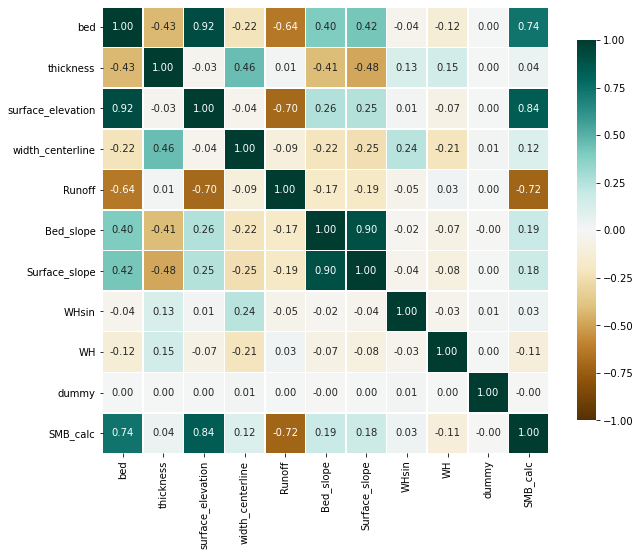

In [26]:
import seaborn as sns
correlation_heatmap(train)


In [27]:
average_precision_xgboost = average_precision_score(test_labels, predictions_xgboost)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_xgboost))

Average precision-recall score: 0.81


Confusion matrix, without normalization
[[43  6]
 [21 28]]


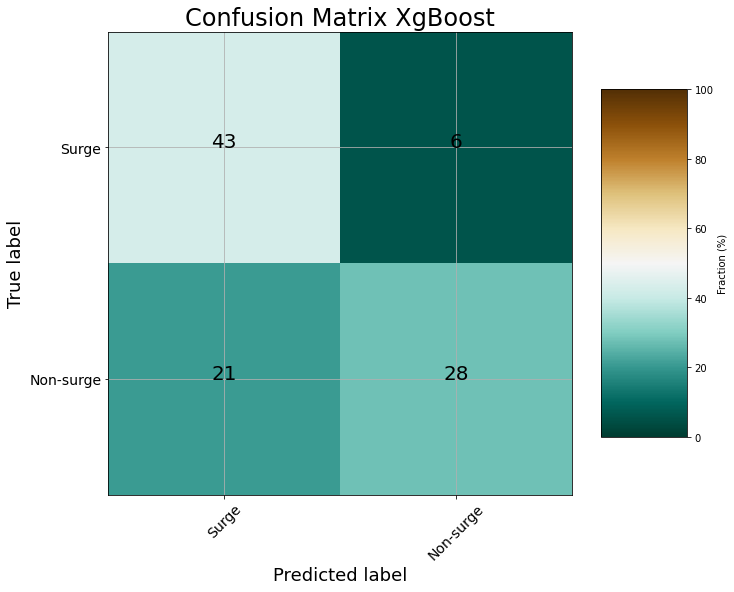

In [28]:
# confusion_matrix(test_labels, predictions.round())
cm_xgboost = confusion_matrix(test_labels, predictions_xgboost.round())
plot_confusion_matrix((cm_xgboost/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix XgBoost', cmap='BrBG_r')

# Feature elimination recursively

In [29]:
#xgb = xgboost.XGBClassifier(**params)
#xgb.fit(train, train_labels)

In [30]:
xgb.get_score(importance_type = 'gain')

{'width_centerline': 2.1710102622124703,
 'thickness': 1.1801200519063266,
 'Surface_slope': 0.6034095741110937,
 'Runoff': 0.801053947213018,
 'bed': 0.5293194411815408,
 'Bed_slope': 0.20165222519226736,
 'SMB_calc': 0.27179885844756374,
 'WH': 0.2267926766141277,
 'WHsin': 0.18308769001642017,
 'surface_elevation': 0.18264531541611814,
 'dummy': 0.1576646976566053}

In [31]:
gain=xgb.get_score(importance_type = 'gain')
weight=xgb.get_score(importance_type = 'weight')

In [32]:
features_gain   = list(dict(sorted(gain.items(), key=lambda item: item[1], reverse=True)).keys())
features_weight = list(dict(sorted(weight.items(), key=lambda item: item[1], reverse=True)).keys())

In [33]:
features_gain

['width_centerline',
 'thickness',
 'Runoff',
 'Surface_slope',
 'bed',
 'SMB_calc',
 'WH',
 'Bed_slope',
 'WHsin',
 'surface_elevation',
 'dummy']

In [34]:
features_weight

['Surface_slope',
 'thickness',
 'Bed_slope',
 'bed',
 'SMB_calc',
 'Runoff',
 'width_centerline',
 'WH',
 'surface_elevation',
 'WHsin',
 'dummy']

In [35]:
l_gain=[]
l_weight=[]
AUC_gain=[]
AUC_weight=[]
for f in features_gain:
    l_gain.append(f)
    select_X_train = train[l_gain]
    select_X_test = test[l_gain]
    
    #Build matrix
    dmatrix_train = xgboost.DMatrix(select_X_train, label=train_labels)
    dmatrix_test = xgboost.DMatrix(select_X_test, label=test_labels)
    
    # train model
    selection_model = xgboost.train(params, dmatrix_train, num_boost_round=20000)

    # eval model
    predictions = selection_model.predict(dmatrix_test)
#     accuracy = accuracy_score(test_labels, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    AUC_gain.append(metrics.roc_auc_score(y_true=test_labels, y_score=predictions))
    
for f in features_weight:
    l_weight.append(f)
    select_X_train = train[l_weight]
    select_X_test = test[l_weight]
    
    #Build matrix
    dmatrix_train = xgboost.DMatrix(select_X_train, label=train_labels)
    dmatrix_test = xgboost.DMatrix(select_X_test, label=test_labels)
    
    # train model
    selection_model = xgboost.train(params, dmatrix_train, num_boost_round=20000)

    # eval model
    predictions = selection_model.predict(dmatrix_test)
#     accuracy = accuracy_score(test_labels, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    AUC_weight.append(metrics.roc_auc_score(y_true=test_labels, y_score=predictions))

[16:29:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:30:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:31:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_boost_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

<ipython-input-53-d7b92a67ac55>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0.75, 0.76, 0.77, 0.78, 0.79, 0.8], fontsize=15)


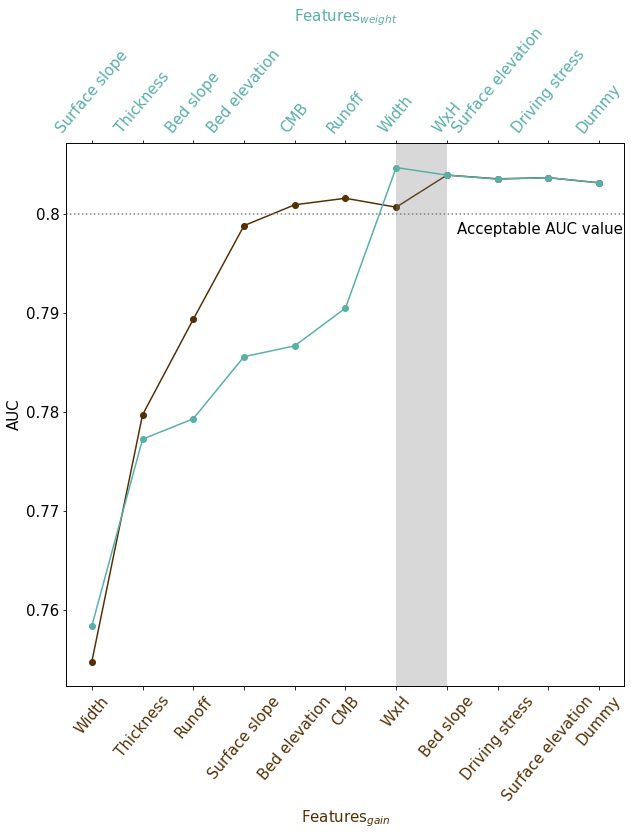

In [53]:
nb_features = np.arange(1, 12, 1)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(nb_features, AUC_gain, color=cmap(0), marker='o')
ax2.plot(nb_features, AUC_weight, color=cmap(0.75), marker='o')
# plt.axvline(x=4, color='grey', linestyle='-')
plt.axvspan(7, 8, facecolor='grey', alpha=0.3)
plt.axhline(0.8, color='grey', linestyle=':')
ax1.set_ylabel('AUC', fontsize=15)
ax1.set_yticklabels([0.75, 0.76, 0.77, 0.78, 0.79, 0.8], fontsize=15)
ax1.set_xlabel('Features$_{gain}$', fontsize=15, color=cmap(0))
ax2.set_xlabel('Features$_{weight}$', fontsize=15, color=cmap(0.75))
plt.text(8.2, 0.798, 'Acceptable AUC value', fontsize=15)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
labels_gain = ['Width',
 'Thickness',
 'Runoff',
 'Surface slope',
 'Bed elevation',
 'CMB',
 'WxH',
 'Bed slope',
 'Driving stress',
 'Surface elevation',
 'Dummy']
labels_weight = ['Surface slope',
 'Thickness',
 'Bed slope',
 'Bed elevation',
 'CMB',
 'Runoff',
 'Width',
 'WxH',
 'Surface elevation',
 'Driving stress',
 'Dummy']

ax1.set_xticks(x)
ax2.set_xticks(x)
ax1.set_xticklabels(labels_gain, rotation=50, color=cmap(0), fontsize=15)
ax2.set_xticklabels(labels_weight, rotation=50, color=cmap(0.75), fontsize=15)
#plt.xticks(x, labels_gain)
#ax.set_xticklabels(labels, rotation=50)
#ax.set_title('Features: Slope/WHsin/Thick./Bed/Runoff/Width/Dummy/SMB/WH/Surf/Terminus', fontsize=15)
plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/feature_elimination.pdf', bbox_inches='tight')